In [1]:
# ExoJulia
## Andrew Lincowski & Spencer Wallace
## Homework 2a: Exoplanet Transits

In [2]:
# Required packages
using LsqFit
using PyPlot

In [3]:
# Random functions
function fastsortrows(B::AbstractMatrix,cols::Array; kws...)
  """
  Solution by: abhishekmalali (gihub)
  See: https://github.com/JuliaLang/julia/issues/9832
  """
       for i = 1:length(cols)
        if i == 1
            p =sortperm(B[:,cols[i]]; kws...);
            B = B[p,:];
        else
            i0_old = 0;
            i1_old = 0;
            i0_new = 0;
            i1_new = 0;
            for j = 1:size(B,1)-1
                if B[j,cols[1:i-1]] == B[j+1,cols[1:i-1]] && i0_old == i0_new
                    i0_new = j;
                elseif B[j,cols[1:i-1]] != B[j+1,cols[1:i-1]] && i0_old != i0_new && i1_new == i1_old
                    i1_new = j;
                elseif i0_old != i0_new && j == size(B,1)-1
                    i1_new = j+1;
                end
                if i0_new != i0_old && i1_new != i1_old
                    p = sortperm(B[i0_new:i1_new,cols[i]]; kws...);
                    B[i0_new:i1_new,:] = B[i0_new:i1_new,:][p,:];
                    i0_old = i0_new;
                    i1_old = i1_new;
                end
            end
            end
    end
    return B
end

fastsortrows (generic function with 1 method)

In [177]:
# Functions

# 1. Compute overlap of two circles as function of their center-center separation (use law of cosines!)



# 2. Compute transit/secondary eclipse of body (no limb darkening)


function pi_crust(delta::Float64,r::Float64)
    # Calculates overlaps of two circles (the sums of their respective pie crusts)
    #r = sqrt(a*a+b*b): separation of circles center-to-center
    #delta = (Rpl/R*)^2
    # r >= 0
    #@printf "r = %f, delta = %f\n" r delta
    #ingress/egress
    if(r >= (1 + sqrt(delta)))
        # outside of transit
        return 0.0
    elseif(r <= (1 - sqrt(delta)))
        # Fully in transit
        return 1.0
    else
        # ingress / egress
        th_st = 2*acos((1+ r*r - delta)/(2*r))
        th_pl = 2*acos((r*r+delta-1)/(2*r*sqrt(delta)))
        alpha = (0.5*th_st - 0.5*sin(th_st) + 0.5*th_pl*delta - 0.5*delta*sin(th_pl))/(pi*delta)
        return alpha
    end
end


# 3. Fit model to mystery_planet2.txt.
#    Calculate planet period P, transit depth K, impact parameter b, and duration of transit T
#    Calculate density of star


function transit(delta,b,t,t0,v,period,base_flux)
    # delta = (Rpl/R*)^2
    # b = impact parameter
    # t = time
    # t0 = time of first contact
    # v = velocity
    # period = period
    
    # prevent bad parameters
    if (delta < 0. || delta > 1. || b < 0. || b > 1. || period < 4./v || t0 >= period || t0 < 0.)
        return typemax(Float64)
    end
    
    t = mod(t,period)
    a = v*(t-t0)-sqrt(1-b^2)-sqrt(delta)
    r = sqrt(a*a+b*b)

    return base_flux*(1 - pi_crust(delta,r)*delta)
end


function transit_model(x,p)
    
    delta = p[1]
    b = p[2]
    t0 = p[3]
    v = p[4]
    period = p[5]
    base_flux = p[6]
    
    tr_arr = Array(Float64,length(x))
    for i in 1:length(x)
        tr_arr[i] = transit(delta,b,x[i],t0,v,period,base_flux)
    end

    return tr_arr
end


# 4. EXTRA: layer cake modelth

transit_model (generic function with 1 method)

In [178]:
Rst = 1.0
Rpl = 0.1
delta = (Rpl/Rst)^2
b = 0.6
v = 5.0
t0 = 0.5
period = 3.0
base_flux = 22000.

delta = 0.00556306
b = 0.0       
t0 = 0.0       
v = 0.328889  
period = 12.1622    
base_flux = 22932.4 

t = linspace(0., 70.,10000)
tr_test = Array(Float64,length(t))

for i in 1:length(t)
    tr_test[i] = transit(delta,b,t[i],t0,v,period,base_flux)
end

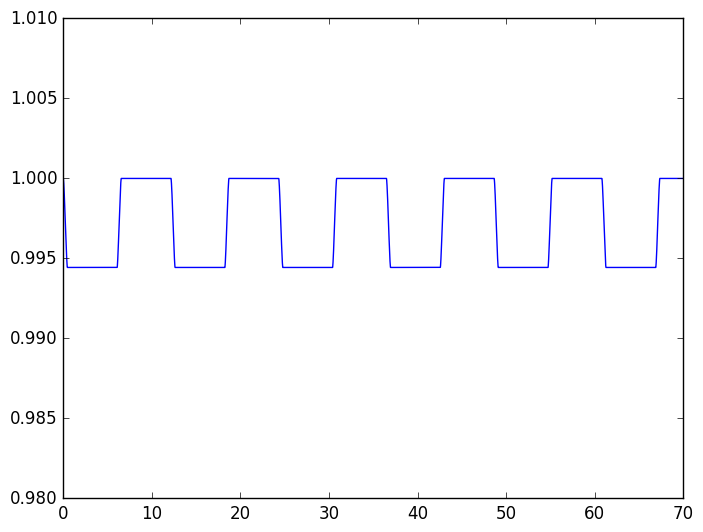

(0.98,1.01)

In [170]:
plot(t,tr_test/base_flux)
ylim([0.98,1.01])
#xlim([0.0,20.0])

In [43]:
# Data import
pldata = readdlm("mystery_planet2.txt")
time_data = pldata[:,1]
flux_data = pldata[:,2]
err_data = pldata[:,3]

10000-element Array{Float64,1}:
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
  ⋮    
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467

In [44]:
#Probe useful parameter space for period of planet orbit
period = linspace(10,25,1000)
sum = Array(Float64,length(period))

for (j,P) in enumerate(period)
    sum[j] = 0.0
    
    #Sort by phase, given period
    phase = Array(Real,length(time_data))
    phase = mod(time_data,P)
    phase_data_arr = [phase flux_data] #combine arrays
    phase_sorted = fastsortrows(phase_data_arr, [1]) #sort by phase
    for i in 2:length(time_data)
        sum[j] += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
    end
end

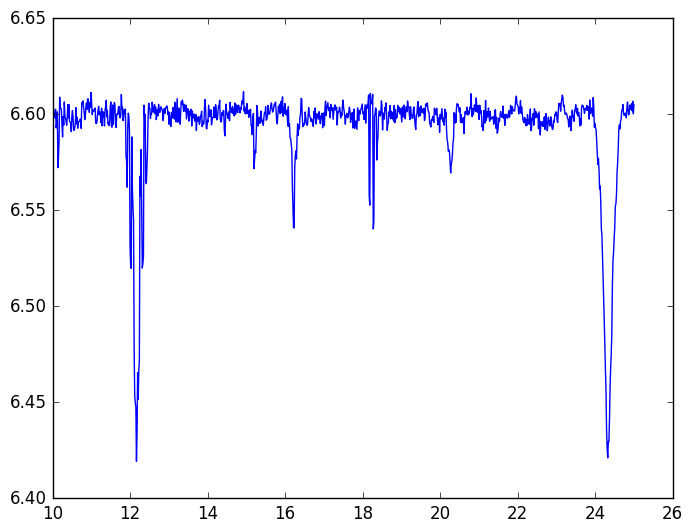

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f503adc9390>

In [45]:
#Plot residuals vs period
plot(period,log10(sum))

In [46]:
#Plot region around minimum of residuals
min_index=indmin(sum)
min_per=period[min_index]

# Period fit (days)
min_per

12.162162162162161

In [11]:
using PyCall
@pyimport scipy as sp
@pyimport scipy.optimize as opt
@pyimport numpy as np
print(sp.__version__)

# Initial values for curve_fit
delta = (maximum(flux_data)-minimum(flux_data))/maximum(flux_data)
b = 0.0
t0 = 0.0
v = 4./min_per
flux = mean(flux_data)

p_bound_low = [0., 0., 0., 4./min_per, -np.inf]
p_bound_hi = [1., 1., np.inf, np.inf, np.inf]

opt.curve_fit(transit_model, time_data, flux_data, p0=[delta,b,t0,v,flux], sigma=err_data)

LoadError: LoadError: UndefVarError: np not defined
while loading In[11], in expression starting on line 14

In [179]:
# Initial values for curve_fit
delta = (maximum(flux_data)-minimum(flux_data))/maximum(flux_data)
b = 0.0
t0 = 0.0
v = 4./min_per
flux = mean(flux_data)

p = [delta,b,t0,v,min_per,flux] #period P from phase folding estimate
for (idx, val) in enumerate(p)
    println(val)
end

# Run fitting routine for eccentricity & time of periastron
fit = curve_fit(transit_model,time_data,flux_data,err_data,p)
fit.param

0.0

6-element Array{Float64,1}:
     0.00556306
     0.0       
     0.0       
     0.328889  
    12.1622    
 22932.4       

055630619131074276
0.0
0.0
0.3288888888888889
12.162162162162161
22932.441338700002


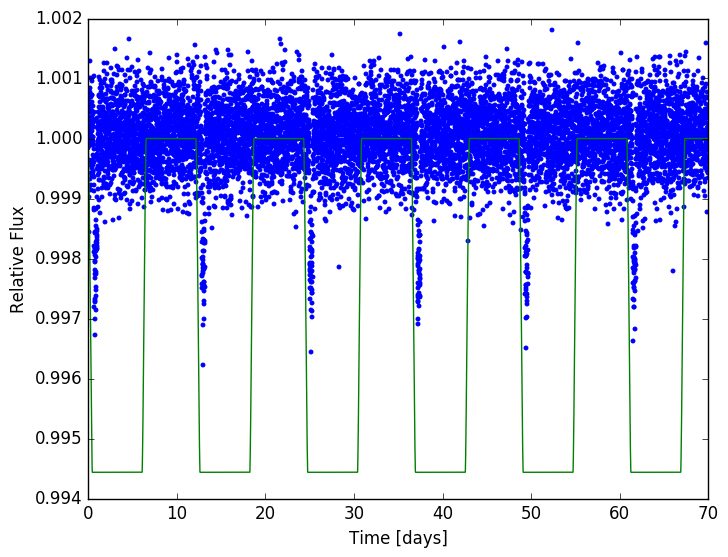

PyObject <matplotlib.text.Text object at 0x7f5037bd4250>

In [180]:
delta = fit.param[1]
b = fit.param[2]
t0 = fit.param[3]
v = fit.param[4]
period = fit.param[5]
base_flux = fit.param[6]

t = linspace(minimum(time_data),maximum(time_data),100000)
tr_test = Array(Float64,length(t))
for i in 1:length(t)
    tr_test[i] = transit(delta,b,t[i],t0,v,period,base_flux)
end

plot(time_data,flux_data/base_flux,".")
plot(t,tr_test/base_flux)
xlabel("Time [days]")
ylabel("Relative Flux")